In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave
import math

import keras

from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, Lambda
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.datasets import mnist
from math import sqrt
from keras.callbacks import History 
import gc
from numpy.random import randint, choice
import numpy.random as rng

import pickle

import keras.backend as K

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Reading Data

In [2]:
##Reading Data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
## Creating Data Map

dataMap = {}
for i in range(10):
    dataMap[i]=[]
    
for i in range(60000):
    
    dataMap[y_train[i]].append((X_train[i].reshape(28,28,1)))
    

In [4]:
## Creating Test Data Map

testDataMap = {}
for i in range(10):
    testDataMap[i]=[]
    
for i in range(10000):
    
    testDataMap[y_test[i]].append(X_test[i].reshape(28,28,1))
    

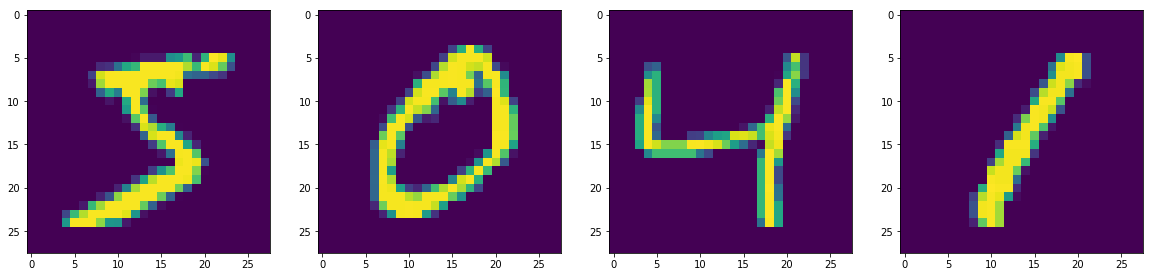

In [5]:
plt.figure(figsize=(20,50))
plt.subplot(141)
plt.imshow(X_train[0])

plt.subplot(142)
plt.imshow(X_train[1])

plt.subplot(143)
plt.imshow(X_train[2])

plt.subplot(144)
plt.imshow(X_train[3])

In [7]:
input_dim = (28,28,1)

### Generator Class

In [8]:
class Generator(keras.utils.Sequence):
    
    def __init__(self,numImages,dataMap):
        
        self.numImages = numImages
        self.dataMap = dataMap
        
        
    def __len__(self):
        
        return 30
    
    def __getitem__(self,index):
        
        pairs, targets = self.getBatch(batch_size,posRatio=0.5, shuffleSubjects=True)
        
        return pairs, targets
        

     
        

    def getBatch(self,batchSize, posRatio = 0.5, shuffleSubjects = True):
    
        
        posSamples = int(batchSize*posRatio)
        negSamples = batchSize - posSamples
        

        #positiveSamples 
        posPairList = []
            
        imgClass = choice(10)  #Select class out of 10 possible classes

        for i in range(posSamples):
            
            if shuffleSubjects==True:
                imgClass = choice(10)

            imgChoice = choice(self.numImages, 2, replace = False)

            img1 = self.dataMap[imgClass][imgChoice[0]]
            img2 = self.dataMap[imgClass][imgChoice[1]]

            posPairList.append(((img1,img2),1))
                

        #negativeSamples
        negPairList = []

        if shuffleSubjects==True:
            
            for i in range(negSamples):
                #Selecting the classes for the negative pair
                imgClasses = list(choice(10, 2,replace=False))
                
                #Selecting the specific image from each image class
                img1Choice = choice(self.numImages, 1, replace = False)
                img2Choice = choice(self.numImages, 1, replace = False)
                
                img1 = self.dataMap[imgClasses[0]][img1Choice[0]]
                img2 = self.dataMap[imgClasses[1]][img2Choice[0]]
                
                negPairList.append(((img1,img2),0))

        pairList = posPairList + negPairList
    

        inputAimgs = np.array([x[0][0] for x in pairList])
        inputBimgs = np.array([x[0][1] for x in pairList])
        target = np.array([x[1] for x in pairList])        

        return( [inputAimgs,inputBimgs], target)
    
    def on_epoch_end(self):
        'Updates to be done after each epoch'
        a = 5
        
        
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = self.getBatch(batch_size,posRatio=0.5, shuffleSubjects=True)
            yield (pairs, targets) 
    
    


### Helper Functions

In [32]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 5
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)
#//TODO: figure out how to initialize layer biases in keras.

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

### Modeling

#### Model 1

In [10]:
baseModel = Sequential()
baseModel.add(BatchNormalization(input_shape = input_dim))
baseModel.add(Conv2D(64, (3,3),activation='relu', data_format='channels_last',kernel_initializer=W_init,strides=(2,2)))
baseModel.add(MaxPooling2D())

baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(128, (3,3),activation='relu',kernel_initializer=W_init, bias_initializer=b_init, strides=(1,1)))
baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(256, (3,3),activation='relu',kernel_initializer=W_init, bias_initializer=b_init))
baseModel.add(Flatten())
baseModel.add(Dense(1028, activation='relu'))
# baseModel.add(Dense(32, activation='relu'))


inputA = Input(shape = input_dim)
inputB = Input(shape = input_dim)

outputA = baseModel(inputA)
outputB = baseModel(inputB)


In [11]:
baseModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)         295168    
__________

In [14]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([outputA,outputB])

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=1e-5, patience=3, verbose=1)


model = Model(input=[inputA, inputB], output=distance)

model.compile(loss=contrastive_loss,optimizer='adadelta')


/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  


In [15]:
gen = Generator(5,dataMap)
val_gen  = Generator(15,testDataMap)

In [16]:
model.fit_generator(gen.generate(30),epochs=15,steps_per_epoch = 250,validation_data=val_gen.generate(30),validation_steps=50,callbacks = [lr_reduce])

Epoch 1/15
250/250 [==============================] - 14s 54ms/step - loss: 0.2030 - val_loss: 0.1927
Epoch 2/15
250/250 [==============================] - 4s 14ms/step - loss: 0.0497 - val_loss: 0.1992
Epoch 3/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0354 - val_loss: 0.1849
Epoch 4/15
250/250 [==============================] - 4s 16ms/step - loss: 0.0290 - val_loss: 0.1721
Epoch 5/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0244 - val_loss: 0.1736
Epoch 6/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0221 - val_loss: 0.1753
Epoch 7/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0201 - val_loss: 0.1735
Epoch 8/15
250/250 [==============================] - 4s 16ms/step - loss: 0.0188 - val_loss: 0.1826

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.1.
Epoch 9/15
250/250 [==============================] - 4s 16ms/step - loss: 0.0148 - val_loss: 0.1706
Epoch 10/15
250/250 [======

#### Model 2

In [39]:
baseModel = Sequential()

baseModel.add(Conv2D(64, (3,3),activation='relu', data_format='channels_last',kernel_initializer=W_init,strides=(1,1),input_shape = input_dim))
# baseModel.add(BatchNormalization(axis=3))
baseModel.add(Conv2D(64, (3,3),activation='relu', data_format='channels_last',kernel_initializer=W_init,strides=(1,1) ))
# baseModel.add(BatchNormalization(axis=3))
baseModel.add(MaxPooling2D(pool_size=(2,2)))
baseModel.add(Dropout(0.3))

baseModel.add(Conv2D(128, (3,3),activation='relu', data_format='channels_last',kernel_initializer=W_init,strides=(1,1)))
# baseModel.add(BatchNormalization(axis=3))
baseModel.add(Dropout(0.3))
baseModel.add(Conv2D(256, (3,3),activation='relu', data_format='channels_last',kernel_initializer=W_init,strides=(1,1) ))
# baseModel.add(BatchNormalization(axis=3))
baseModel.add(Conv2D(256, (3,3),activation='relu', data_format='channels_last',kernel_initializer=W_init,strides=(1,1) ))
# baseModel.add(BatchNormalization(axis=3))
baseModel.add(MaxPooling2D(pool_size=(2,2)))


baseModel.add(Dropout(0.3))
baseModel.add(Flatten())
baseModel.add(Dense(256, activation='relu'))

inputA = Input(shape = input_dim)
inputB = Input(shape = input_dim)

outputA = baseModel(inputA)
outputB = baseModel(inputB)


In [40]:
baseModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 128)       73856     
_________________________________________________________________
dropout_10 (Dropout)         (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)         295168    
__________

In [41]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([outputA,outputB])

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=1e-5, patience=3, verbose=1)


model = Model(input=[inputA, inputB], output=distance)

model.compile(loss=contrastive_loss,optimizer='adadelta')


/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  


In [42]:
gen = Generator(10,dataMap)
val_gen  = Generator(30,testDataMap)

In [45]:
model.fit_generator(gen.generate(40),epochs=3,steps_per_epoch = 250,validation_data=val_gen.generate(30),validation_steps=50,callbacks = [lr_reduce])

Epoch 1/3
250/250 [==============================] - 15s 59ms/step - loss: 0.0164 - val_loss: 2.5524
Epoch 2/3
250/250 [==============================] - 15s 58ms/step - loss: 0.0156 - val_loss: 2.5828
Epoch 3/3
250/250 [==============================] - 15s 58ms/step - loss: 0.0154 - val_loss: 2.5235


### Testing

In [17]:
def getSupportImgs(numImages,numClasses=10):
    """
    Returns images from training data that would be used as supporting images during the prediction task
    
    numImages : Number of images to be used for testing against each class
    
    """
    
    supportImg = {}
    
    for imgClass in range(numClasses):
        
        supportImg[imgClass]=[]
        
        imgChoices = choice(len(dataMap[imgClass]), numImages, replace=False)
        
        for i in range(numImages):
            img = dataMap[imgClass][imgChoices[i]]
            supportImg[imgClass].append(img)
                        
    return supportImg


def testImg(img,imgSupport,model,printPredList = False):
    """
    Tests an individual image against the support images from each class and returns the class with lowest average
    score
    """
    
    bestScore = 10.0
    bestLabel = ''
    bestImg = 0.0
    predList = []
    
    
    for imgClass in list(imgSupport.keys()):
        trainImgs = imgSupport[imgClass]
        
        scores = []
        
        for i in range(len(trainImgs)):
            pred = model.predict([img.reshape(1,28,28,1), trainImgs[i].reshape(1,28,28,1) ])
            scores.append(pred[0])
        
        avgScore = np.sum(scores)/float(len(trainImgs))
        predList.append([imgClass, avgScore])
        
        if avgScore < bestScore:
            bestScore = avgScore
            bestLabel = imgClass
    
    if printPredList == True:
        for i in range(len(predList)):
            print("Class {} : {}".format(predList[i][0] , predList[i][1]))
    
    return(bestLabel, bestScore)
            

In [18]:
def testClass(imgClass, model, numTestImages=100, supportImgCount=1,verbose = True):
    """
    Tests numTestImages number of images from the test data for the imgClass class of images and reports the accuracy
    
    """
    
    supportImg = getSupportImgs(1)
    
    imgChoices = list(choice(len(testDataMap[imgClass]) , numTestImages, replace = False ))
    
    preds = []
    
    for imgNo in imgChoices:
        img = testDataMap[imgClass][imgNo]
        bestLabel = testImg(img, supportImg, model)[0]
        
        if verbose:
            print("Img # : {} Predicted Label : {}".format(imgNo, bestLabel))
        
        if bestLabel == imgClass:
            preds.append(1.0)
        else:
            preds.append(0.0)
    
    accuracy = np.sum(preds)/float(len(preds))
    
    if verbose:
        print("Class : {} Images Tested : {} Accuracy : {}".format(imgClass, numTestImages, accuracy))
    
    return accuracy
    
    
    
    

In [19]:
x = testClass(5,model,100,100)

Img # : 240 Predicted Label : 4
Img # : 583 Predicted Label : 4
Img # : 638 Predicted Label : 4
Img # : 658 Predicted Label : 4
Img # : 185 Predicted Label : 4
Img # : 210 Predicted Label : 4
Img # : 444 Predicted Label : 5
Img # : 838 Predicted Label : 5
Img # : 611 Predicted Label : 4
Img # : 38 Predicted Label : 4
Img # : 667 Predicted Label : 4
Img # : 65 Predicted Label : 4
Img # : 319 Predicted Label : 6
Img # : 777 Predicted Label : 4
Img # : 571 Predicted Label : 5
Img # : 668 Predicted Label : 4
Img # : 372 Predicted Label : 5
Img # : 704 Predicted Label : 6
Img # : 679 Predicted Label : 5
Img # : 560 Predicted Label : 4
Img # : 248 Predicted Label : 5
Img # : 575 Predicted Label : 0
Img # : 644 Predicted Label : 4
Img # : 605 Predicted Label : 5
Img # : 745 Predicted Label : 5
Img # : 405 Predicted Label : 4
Img # : 66 Predicted Label : 6
Img # : 579 Predicted Label : 4
Img # : 30 Predicted Label : 5
Img # : 57 Predicted Label : 5
Img # : 865 Predicted Label : 4
Img # : 724 P

In [30]:
def testModel(model, numTestImages = 100,supportImgCount = 100):
    
    correctPreds = 0.0
    
    for i in range(10):
        acc = testClass(i,model,numTestImages,supportImgCount,False)
        correctPreds += acc*numTestImages
        print("Class {} : {}".format(i, acc))
        
    totalAccuracy = correctPreds/(10*numTestImages)
    
    print("Total Accuracy : {}".format(totalAccuracy))
    
    return totalAccuracy

In [29]:
testModel(model)

Class 0 : 0.87
Class 1 : 0.99
Class 2 : 0.66
Class 3 : 0.45
Class 4 : 0.84
Class 5 : 0.68
Class 6 : 0.95
Class 7 : 0.9
Class 8 : 0.59
Class 9 : 0.71
Total Accuracy : 0.764


In [46]:
scores = []

for i in range(5):
    scores.append(testModel(model))
    
print(np.mean(scores))

Class 0 : 0.99
Class 1 : 0.91
Class 2 : 0.31
Class 3 : 0.73
Class 4 : 0.84
Class 5 : 0.78
Class 6 : 0.89
Class 7 : 0.74
Class 8 : 0.73
Class 9 : 0.93
Total Accuracy : 0.785
Class 0 : 0.95
Class 1 : 0.91
Class 2 : 0.87
Class 3 : 0.82
Class 4 : 0.81
Class 5 : 0.6
Class 6 : 0.9
Class 7 : 0.92
Class 8 : 0.87
Class 9 : 0.84
Total Accuracy : 0.849
Class 0 : 0.99
Class 1 : 0.85
Class 2 : 0.94
Class 3 : 0.82
Class 4 : 0.81
Class 5 : 0.53
Class 6 : 0.97
Class 7 : 0.72
Class 8 : 0.82
Class 9 : 0.92
Total Accuracy : 0.837
Class 0 : 0.97
Class 1 : 0.94
Class 2 : 0.9
Class 3 : 0.89
Class 4 : 0.78
Class 5 : 0.59
Class 6 : 0.91
Class 7 : 0.85
Class 8 : 0.85
Class 9 : 0.0
Total Accuracy : 0.768
Class 0 : 0.13
Class 1 : 0.88
Class 2 : 0.87
Class 3 : 0.84
Class 4 : 0.79
Class 5 : 0.49
Class 6 : 0.93
Class 7 : 0.77
Class 8 : 0.96
Class 9 : 0.53
Total Accuracy : 0.719
0.7916


#### Loading Models

In [27]:
class winit:
    def __call__(self, shape, dtype=None):
        return W_init(shape)
    
class binit:
    def __call__(self, shape, dtype=None):
        return b_init(shape)
    

from keras.utils import CustomObjectScope

with CustomObjectScope({'W_init': winit}):
    model = load_model(os.path.join(os.getcwd(),"Models","300images_0.98acc_model2_100support.hdf5"),custom_objects={'contrastive_loss':contrastive_loss})

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 256)          1587776     input_15[0][0]                   
                                                                 input_16[0][0]                   
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 1)            0           sequential_9[1][0]               
          

In [45]:
model.save(os.path.join(os.getcwd(),"Models","1000images_0.986acc_model2_100support.hdf5"))

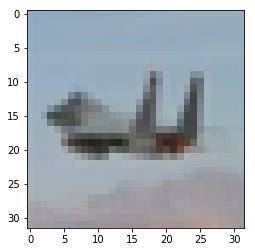

In [224]:
plt.imshow(testDataMap[0][406])

In [228]:
q = testDataMap[0][406]
support = getSupportImgs(numImages=1)

testImg(q, support, model,True)

Class 0 : 0.841515004635
Class 1 : 0.412214666605
Class 2 : 1.30040335655
Class 3 : 1.80947625637
Class 4 : 1.59980964661
Class 5 : 1.67032849789
Class 6 : 1.70729362965
Class 7 : 1.0017260313
Class 8 : 0.432438015938
Class 9 : 0.738957881927


(1, 0.4122146666049957)

In [229]:
def predNPrint(img1,img2,model):
    
    pred = model.predict([img1.reshape(1,32,32,3), img2.reshape(1,32,32,3) ])
    
    print(pred)
    
    plt.subplot(121)
    plt.imshow(img1)
    
    plt.subplot(122)
    plt.imshow(img2)
    
    
    

[[1.8094763]]


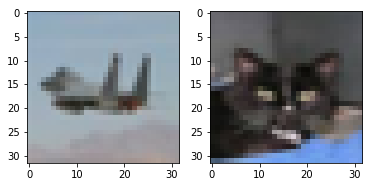

In [233]:
predNPrint(q,support[3][0],model)